In [1]:
from neural_network import NeuralNetwork
from data import Instance, DataSet
from miscellaneous import initialize_data, plot_graph, plot_points
from activation_function import *
import matplotlib.pyplot as plt
import pandas as pd
import copy
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
import itertools
import time
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Carregando dados e Ajustando labels

In [3]:
start_time = time.time()

# Carregando dados
print('Carregando dados ...', end = '')
champ_stats = pd.read_csv('../dataset/champ_stats.csv')
champs = pd.read_csv('../dataset/champs.csv')
participants = pd.read_csv('../dataset/participants.csv')
print( 28*'.'+' OK')

# Ajustando nomes
print('Ajustando nomes[1] ...', end = '')
champ_stats_labels = [i.lower() for i in champ_stats.columns.values]
rename_dict_champ_stats = { i: j for i,j in zip(champ_stats.columns.values, champ_stats_labels) }
champ_stats.rename(columns = rename_dict_champ_stats, inplace = True)
print( 26*'.'+' OK')

# Ajustando nomes
print('Ajustando nomes[2] ...', end = '')
champs_labels = [i.lower() for i in champs.columns.values]
rename_dict_champs = { i: j for i,j in zip(champs.columns.values, champs_labels) }
champs.rename(columns = rename_dict_champs, inplace = True)
print( 26*'.'+' OK')

# Removendo instâncias desnecessárias
print('Removendo instâncias desnecessárias ...', end = '')
champ_stats['name'] = champ_stats['name'].str.replace('\'', '')
champ_stats['name'] = champ_stats['name'].str.replace('\. ', '')
champ_stats = champ_stats[champ_stats['name'].isin(champs['name'])].reset_index(drop = True)
champs = champs.sort_values('name').reset_index(drop = True)
print( 9*'.'+' OK')

# Reduzindo dimensionalidade
print('Reduzindo dimensionalidade ...', end = '')
params = ['hp', 'hp5', 'mp', 'mp5', 'ad', 'ar', 'mr']
for param in params:
    champ_stats[param] = champ_stats[param] + 10*champ_stats[param+'+']
    champ_stats.drop(columns = [param+'+'], inplace = True)
    
champ_stats['as'] = champ_stats['as'] * ((1 + champ_stats['as+'])**10)
champ_stats.drop(columns = ['as+'], inplace = True)
print( 18*'.'+' OK')

# Removendo atributos desnecessários
print('Removendo atributos desnecessários ...', end = '')
participants.drop(columns = ['player', 'ss1', 'ss2', 'id', 'matchid'], inplace = True)
print( 10*'.'+' OK')

# Reconstruindo linhas apropriadamente
print('Reconstruindo linhas apropriadamente ...', end = '')
final_frame = pd.DataFrame()
p = 0
for i in range(2):
    for j in range(5):
        p = participants[i*5+j::10].rename( columns = {'championid': 'championid_'+str(i)+str(j), 'role': 'role_'+str(i)+str(j), 'position': 'position_'+str(i)+str(j)} )
        if(final_frame.empty):
            final_frame = pd.DataFrame.copy(p).reset_index(drop = True)
        else:
            final_frame = final_frame.join(pd.DataFrame.copy(p).reset_index(drop = True))
participants = final_frame
print( 8*'.'+' OK')
    
# Substituindo IDs por nomes dos champions
print('Substituindo IDs por nomes dos champions ...', end = '')
for i in range(2):
    for j in range(5):
        s = champs.set_index('id')['name']
        participants['championid_'+str(i)+str(j)] = participants['championid_'+str(i)+str(j)].replace(s)
        print('\rSubstituindo IDs por nomes dos champions ....... ' + str(i*5+j+1) + '/10', end = '')
print('\rSubstituindo IDs por nomes dos champions ...', end = '')
print( 4*'.'+' OK       ')
        
# Juntando tabelas
print('Juntando tabelas ...', end = '')
params = ['hp', 'hp5', 'mp', 'mp5', 'ad', 'ar', 'as', 'mr', 'ms', 'range']
s = champ_stats.set_index('name')
for i in range(2):
    for j in range(5):
        for param in params:
            participants[param+'_'+str(i)+str(j)] = participants['championid_'+str(i)+str(j)]
            participants[param+'_'+str(i)+str(j)] = participants[param+'_'+str(i)+str(j)].replace(s[param])
            print('\rJuntando tabelas ...' + 28*'.' + ' ' + str(i*5+j+1) + '/10 - ' + param + '    ', end = '')
print('\rJuntando tabelas ...', end = '')
print( 28*'.'+' OK               ')

# Removendo o nome dos champios
print('Removendo o nome dos champios ...', end = '')
for i in range(2):
    for j in range(5):
        participants.drop(columns = ['championid_'+str(i)+str(j)], inplace = True)
print( 15*'.'+' OK      ')

# One-hot encoding para role e position
print('One-hot encoding para role e position ...', end = '')
for i in range(2):
    for j in range(5):
        participants = pd.concat([participants, pd.get_dummies( participants['role_'+str(i)+str(j)], prefix = 'role_'+str(i)+str(j))],axis=1)
        participants = pd.concat([participants, pd.get_dummies( participants['position_'+str(i)+str(j)], prefix = 'position_'+str(i)+str(j))],axis=1)
        participants.drop(['role_'+str(i)+str(j), 'position_'+str(i)+str(j), 'role_'+str(i)+str(j)+'_NONE'], axis = 1, inplace = True)
        if 'role_' + str(i) + str(j) + '_DUO' not in participants.columns.values:
            participants['role_' + str(i) + str(j) + '_DUO'] = 0
print( 7*'.'+' OK        ')
        
        
# Reordenando atributos
print('Reordenando atributos ...', end = '')
params = ['role', 'position'] + params
atribute_list_final = []
for i in range(2):
    for j in range(5):
        for param in params:
            if(param == 'role'):
                for k in ['SOLO', 'DUO', 'DUO_CARRY', 'DUO_SUPPORT']:
                    atribute_list_final.append(param+'_'+str(i)+str(j)+'_'+k)
            elif(param == 'position'):
                for k in ['BOT', 'MID', 'TOP', 'JUNGLE']:
                    atribute_list_final.append(param+'_'+str(i)+str(j)+'_'+k)
            else:
                atribute_list_final.append(param+'_'+str(i)+str(j))

participants = participants[atribute_list_final]
print( 23*'.'+' OK      ')

#print(participants.columns.values)
        
elapsed_time = time.time() - start_time
print('Tempo total ' + 33*'.' + ' ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))
                                                       
#champ_stats.head()
#champs.head()
display(participants)

Carregando dados ............................... OK
Ajustando nomes[1] ............................. OK
Ajustando nomes[2] ............................. OK
Removendo instâncias desnecessárias ............ OK
Reduzindo dimensionalidade ..................... OK
Removendo atributos desnecessários ............. OK
Reconstruindo linhas apropriadamente ........... OK
Substituindo IDs por nomes dos champions ....... OK       
Juntando tabelas ............................... OK               
Removendo o nome dos champios .................. OK      
One-hot encoding para role e position .......... OK        
Reordenando atributos .......................... OK      
Tempo total ................................. 03:52


,role_00_SOLO,role_00_DUO,role_00_DUO_CARRY,role_00_DUO_SUPPORT,position_00_BOT,position_00_MID,position_00_TOP,position_00_JUNGLE,hp_00,hp5_00,...,hp_14,hp5_14,mp_14,mp5_14,ad_14,ar_14,as_14,mr_14,ms_14,range_14
0,0,0,0,0,0,0,0,1,1400.00,11.5,...,1400.00,11.0,679.00,16.000,86.3539,56.880,0.715395,35.0,340,525
1,0,0,0,1,1,0,0,0,1456.00,12.5,...,1400.00,11.5,630.00,13.216,93.0000,65.000,0.800898,44.6,335,125
2,0,0,1,0,1,0,0,0,1377.76,13.0,...,1335.08,12.0,687.20,11.756,87.1000,62.000,0.946749,35.0,330,550
3,1,0,0,0,0,1,0,0,1448.00,13.0,...,1388.00,12.5,775.00,12.000,80.0000,57.216,0.715395,35.0,325,550
4,1,0,0,0,0,1,0,0,1440.00,12.5,...,1459.48,11.5,940.80,19.000,90.4600,63.384,0.727485,35.0,335,450
5,0,0,1,0,1,0,0,0,1380.00,12.5,...,1393.00,15.5,100.00,0.000,92.0000,64.000,0.857657,42.5,345,175
6,0,0,0,0,0,0,0,1,1518.56,14.0,...,1400.00,11.5,630.00,13.216,93.0000,65.000,0.800898,44.6,335,125
7,0,0,0,0,0,0,0,1,1518.56,14.0,...,1400.00,11.5,630.00,13.216,93.0000,65.000,0.800898,44.6,335,125
8,1,0,0,0,0,1,0,0,1340.00,11.0,...,1325.00,11.0,663.70,12.900,83.8000,67.000,0.840779,35.0,325,650
9,1,0,0,0,0,0,1,0,1535.60,17.5,...,1400.00,11.5,630.00,13.216,93.0000,65.000,0.800898,44.6,335,125


In [44]:
inp = pd.DataFrame.copy(participants)

min_max_s = MinMaxScaler(feature_range = (0.0, 1.0))

for col in inp:
    inp[col] = min_max_s.fit_transform(inp[col].values.reshape(-1, 1))
    
display(inp)

,role_00_SOLO,role_00_DUO,role_00_DUO_CARRY,role_00_DUO_SUPPORT,position_00_BOT,position_00_MID,position_00_TOP,position_00_JUNGLE,hp_00,hp5_00,...,hp_14,hp5_14,mp_14,mp5_14,ad_14,ar_14,as_14,mr_14,ms_14,range_14
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.560748,0.300000,...,0.560748,0.266667,0.636006,0.32000,0.444805,0.489492,0.188214,0.023669,0.625,0.761905
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.647975,0.366667,...,0.560748,0.300000,0.590109,0.26432,0.561404,0.627119,0.360069,0.591716,0.500,0.000000
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.526106,0.400000,...,0.459626,0.333333,0.643687,0.23512,0.457895,0.576271,0.653223,0.023669,0.375,0.809524
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.635514,0.400000,...,0.542056,0.366667,0.725927,0.24000,0.333333,0.495186,0.188214,0.023669,0.250,0.809524
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.623053,0.366667,...,0.653396,0.300000,0.881229,0.38000,0.516842,0.599729,0.212513,0.023669,0.500,0.619048
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.529595,0.366667,...,0.549844,0.566667,0.093668,0.00000,0.543860,0.610169,0.474151,0.467456,0.750,0.095238
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.745421,0.466667,...,0.560748,0.300000,0.590109,0.26432,0.561404,0.627119,0.360069,0.591716,0.500,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.745421,0.466667,...,0.560748,0.300000,0.590109,0.26432,0.561404,0.627119,0.360069,0.591716,0.500,0.000000
8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.467290,0.266667,...,0.443925,0.266667,0.621675,0.25800,0.400000,0.661017,0.440228,0.023669,0.250,1.000000
9,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.771963,0.700000,...,0.560748,0.300000,0.590109,0.26432,0.561404,0.627119,0.360069,0.591716,0.500,0.000000


##### Encontrando correlações

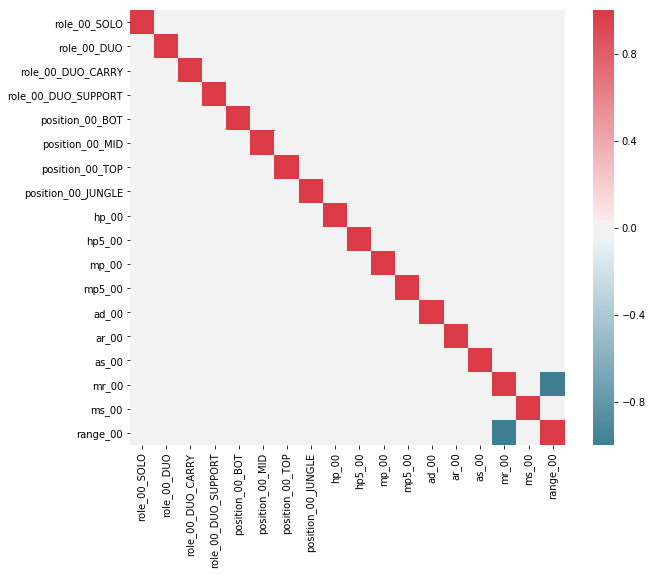

In [45]:
corr = inp[atribute_list_final[0:18]].corr() * (0.5 / 0.8)
corr = corr.round(0)

f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True, ax = ax)

In [46]:
for i in range(2):
    for j in range(5):
        inp.drop(['range_'+str(i)+str(j)], axis = 1, inplace = True)

display(inp)

,role_00_SOLO,role_00_DUO,role_00_DUO_CARRY,role_00_DUO_SUPPORT,position_00_BOT,position_00_MID,position_00_TOP,position_00_JUNGLE,hp_00,hp5_00,...,position_14_JUNGLE,hp_14,hp5_14,mp_14,mp5_14,ad_14,ar_14,as_14,mr_14,ms_14
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.560748,0.300000,...,0.0,0.560748,0.266667,0.636006,0.32000,0.444805,0.489492,0.188214,0.023669,0.625
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.647975,0.366667,...,1.0,0.560748,0.300000,0.590109,0.26432,0.561404,0.627119,0.360069,0.591716,0.500
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.526106,0.400000,...,0.0,0.459626,0.333333,0.643687,0.23512,0.457895,0.576271,0.653223,0.023669,0.375
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.635514,0.400000,...,0.0,0.542056,0.366667,0.725927,0.24000,0.333333,0.495186,0.188214,0.023669,0.250
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.623053,0.366667,...,0.0,0.653396,0.300000,0.881229,0.38000,0.516842,0.599729,0.212513,0.023669,0.500
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.529595,0.366667,...,0.0,0.549844,0.566667,0.093668,0.00000,0.543860,0.610169,0.474151,0.467456,0.750
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.745421,0.466667,...,1.0,0.560748,0.300000,0.590109,0.26432,0.561404,0.627119,0.360069,0.591716,0.500
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.745421,0.466667,...,1.0,0.560748,0.300000,0.590109,0.26432,0.561404,0.627119,0.360069,0.591716,0.500
8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.467290,0.266667,...,0.0,0.443925,0.266667,0.621675,0.25800,0.400000,0.661017,0.440228,0.023669,0.250
9,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.771963,0.700000,...,1.0,0.560748,0.300000,0.590109,0.26432,0.561404,0.627119,0.360069,0.591716,0.500


##### Construindo conjuntos de treino e teste

In [14]:
x_train = train.filter(['pclass', 'sex', 'age', 'fare', 'embarked'], axis = 1)
y_train = train.filter(['survived'], axis = 1)

x_test = test.filter(['pclass', 'sex', 'age', 'fare', 'embarked'], axis = 1)
y_test = test.filter(['survived'], axis = 1)

x_train_list = x_train.values.tolist()

y_train_list = []
for i in y_train.values.tolist():
    if(i[0] >= 0.5):
        y_train_list.append([1.0, 0.0])
    else:
        y_train_list.append([0.0, 1.0])
        
x_test_list = x_test.values.tolist()

y_test_list = []
for i in y_test.values.tolist():
    if(i[0] >= 0.5):
        y_test_list.append([1.0, 0.0])
    else:
        y_test_list.append([0.0, 1.0])

dataset = DataSet() 
for inst_x, inst_y in zip(x_train_list, y_train_list):
    dataset.add(Instance(inst_x, inst_y))
train_final_size = dataset.size() 
    
for inst_x, inst_y in zip(x_test_list, y_test_list):
    dataset.add(Instance(inst_x, inst_y))
test_final_size = dataset.size() - train_final_size
total_final_size = train_final_size + test_final_size

In [15]:
print("Treino: ", train_final_size * 8 // 10)
print("Validação: ", train_final_size * 2 // 10)
print("Teste: ", test_final_size)
print("Total: ", total_final_size)
tvt = [train_final_size * 0.8, train_final_size * 0.2, test_final_size]

Treino:  553
Validação:  138
Teste:  319
Total:  1011


##### Treinamento (Holdout)

In [16]:
net = NeuralNetwork(5, [30, 10, 2], [relu_func, relu_func, soft_max_func], dropout = [0.5, 0.5, 0.5])
data = net.fit(dataset, "mini-batch", 500, lr_ = 0.001, type = "class", mini_batch_size = 20, 
                      tvt_ratio = tvt, print_info = False, opt = 'adam',  loss_ = "categorical_crossentropy")

320/320 [==============================] - 0s 377us/step
[0.49318952672183514, 0.7781249992549419]


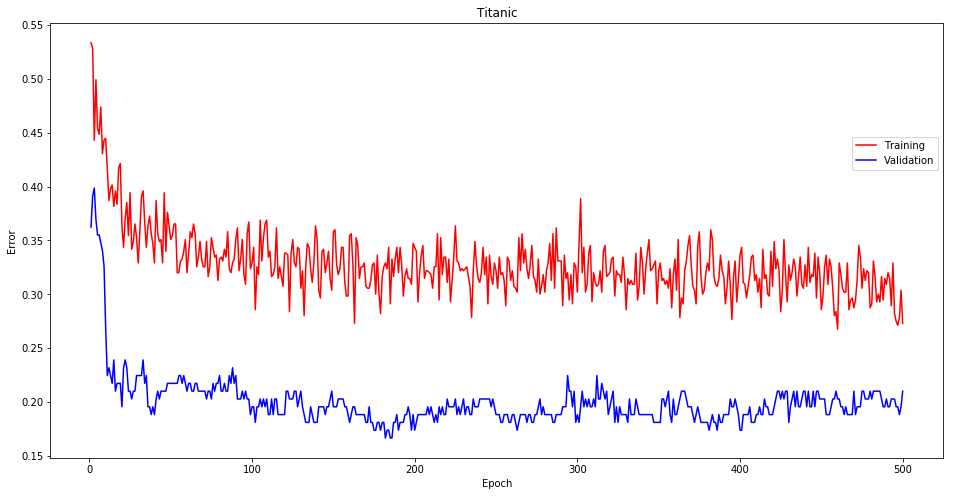

In [17]:
plot_graph(data, "Titanic", "Epoch", "Error", figsizex = 16, figsizey = 8)

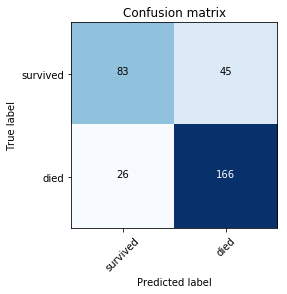

Test Accuracy:  77.8125 %


In [19]:
correct = []
predict = []
for i in range(len(net.confusion_matrix)):
    for j in range(len(net.confusion_matrix)):
        correct = correct + net.confusion_matrix[i][j] * [i]
        predict = predict + net.confusion_matrix[i][j] * [j]
            
mat = confusion_matrix(correct, predict)
plot_confusion_matrix(mat, classes = ['survived', 'died'], title = 'Confusion matrix')
plt.show()

correct_count = 0
total_count = 0
for i in range(len(net.confusion_matrix)):
    for j in range(len(net.confusion_matrix)):
        total_count += net.confusion_matrix[i][j]
        if(i == j):
            correct_count += net.confusion_matrix[i][j]

print('Test Accuracy: ', correct_count/total_count * 100, '%')

##### Treinamento (Cross-validation)

In [ ]:
n_split = 10
kfold = StratifiedKFold(n_splits = n_split, shuffle = True, random_state = 11403723)

idx = 1
data_cv_mean = [0, 0, 0]
matrix_mean = []
for a, b in kfold.split(x_train, y_train):
    
    print("\rTraining fold: ", idx)
    idx += 1
    dataset = None
    dataset = DataSet()
    
    for ind in a:
        dataset.add(Instance(x_train_list[ind], y_train_list[ind]))
    
    for ind in b:
        dataset.add(Instance(x_train_list[ind], y_train_list[ind]))
        
    for ind in range(len(x_test_list)):
        dataset.add(Instance(x_test_list[ind], y_test_list[ind]))
        
    tvt = [len(a), len(b), len(x_test_list)]

    net_cv = NeuralNetwork(5, [30, 10, 2], [relu_func, relu_func, soft_max_func], dropout = [0.5, 0.5, 0.5])
    data_cv = net_cv.fit(dataset, "mini-batch", 500, lr_ = 0.001, type = "class", mini_batch_size = 20, 
                         tvt_ratio = tvt, print_info = False, opt = 'adam', loss_ = "categorical_crossentropy")
    
    if data_cv_mean[0] == 0:
        data_cv_mean = data_cv.copy()
        matrix_mean = net_cv.confusion_matrix.copy()
    else:
        data_cv_mean[1] = [ i+j for i, j in zip(data_cv_mean[1], data_cv[1]) ]
        data_cv_mean[2] = [ i+j for i, j in zip(data_cv_mean[2], data_cv[2]) ]
        
        for i in range(len(matrix_mean)):
            for j in range(len(matrix_mean[i])):
                matrix_mean[i][j] += net_cv.confusion_matrix[i][j]
                

data_cv_mean[1] = [ elem/n_split for elem in data_cv_mean[1]]
data_cv_mean[2] = [ elem/n_split for elem in data_cv_mean[2]]
matrix_mean = [ [ kk//n_split for kk in k ] for k in matrix_mean ]

n = NeuralNetwork(1, [2], [sig_func])
n.confusion_matrix = matrix_mean

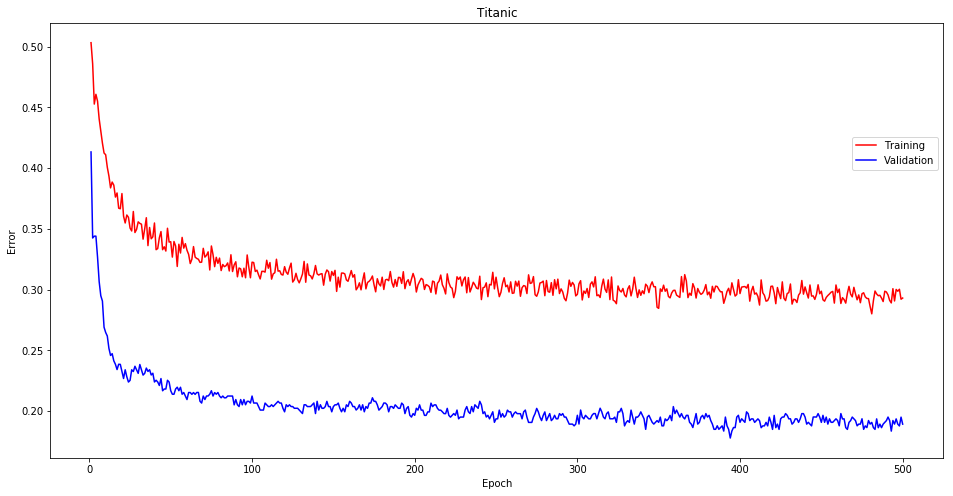

In [68]:
plot_graph(data_cv_mean, "Titanic", "Epoch", "Error", figsizex = 16, figsizey = 8)

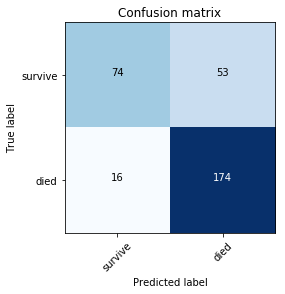

Test Accuracy:  78.99686520376176 %


In [69]:
correct = []
predict = []
for i in range(len(n.confusion_matrix)):
    for j in range(len(n.confusion_matrix)):
        correct = correct + n.confusion_matrix[i][j] * [i]
        predict = predict + n.confusion_matrix[i][j] * [j]
            
mat = confusion_matrix(correct, predict)
plot_confusion_matrix(mat, classes = ['survive', 'died'], title = 'Confusion matrix')
plt.show()

correct_count = 0
total_count = 0
for i in range(len(net.confusion_matrix)):
    for j in range(len(net.confusion_matrix)):
        total_count += net.confusion_matrix[i][j]
        if(i == j):
            correct_count += net.confusion_matrix[i][j]

print('Test Accuracy: ', correct_count/total_count * 100, '%')